---

## 🔄 AUSFÜHRUNGSREIHENFOLGE - QUICK GUIDE

**2 Workflows: Komplett vs. Hybrid-Strategie testen**

---

### ⚡ WORKFLOW 1: SCHNELLSTART (DeepAR Training)

**Ziel:** Modell trainieren mit existierenden Daten

```
Zelle 2  → Imports
Zelle 3  → Config
Zelle 5  → Daten laden
Zelle 7  → Temporal Features
Zelle 9  → Feature Engineering
Zelle 11 → Train/Test Split
Zelle 13 → Scaling
Zelle 16 → Sequences erstellen
Zelle 18 → EDA & Stats
Zelle 21 → Model definieren
Zelle 22 → Model kompilieren
Zelle 24 → Training
Zelle 26 → Predictions
Zelle 27 → Evaluation & Plots
```

**Dauer:** ~5-10 Minuten (je nach Hardware)

---

### 🚀 WORKFLOW 2: HYBRID-STRATEGIE TESTEN

**Ziel:** External Features API & Daten-Management testen

```
Zelle 51 → Setup (Ordner, Manager)
Zelle 52 → Phase 1: Development Cache
Zelle 53 → Phase 2: Training Snapshot
Zelle 54 → Phase 3: Test Snapshot (optional)
Zelle 55 → Snapshot Übersicht
Zelle 56 → Kombiniertes Dataset
```

**Dauer:** ~2-3 Minuten (erste API-Calls)

---

### 💡 EMPFEHLUNG:

**Wenn du NEU bist:**
→ Starte mit Workflow 1 (DeepAR Training)
→ Verstehe das Modell zuerst
→ Dann teste Workflow 2 (Features)

**Wenn du die Hybrid-Strategie testen willst:**
→ Springe direkt zu Zelle 51
→ Teste Feature-Export
→ Kombiniere später mit Training

---

# 🎯 Retail Inventory Forecast - FINAL OPTIMAL

**Projekt:** Vorhersage von Units Sold für Retail Stores  
**Modell:** Bidirektionales LSTM mit 2 Layern  
**Status:** Optimale Balance zwischen Varianz (Std ~10) und Overfitting (<1.3)

**Optimierungen gegenüber Experiment 2.1:**
- Batch Size: 256 → 384 (glattere Gradienten)
- Dropout: 0.2 → 0.25 (weniger Overfitting)
- L2 Reg: 0.0001 → 0.00015 (stärkere Regularisierung)
- Patience: 10 → 8 (früher stoppen)


In [5]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Tuple
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 5)

In [6]:
@dataclass
class Config:
    """Zentrale Konfiguration - alle Parameter hier definiert!"""
    # Pfade
    data_path: str
    target_col: str
    
    # Sequenz & Training
    seq_length: int
    test_size: float
    batch_size: int
    epochs: int
    patience: int
    
    # Model Architektur
    use_bidirectional: bool
    lstm_layers: int
    lstm_units_1: int
    lstm_units_2: int
    dense_units: int
    dense_activation: str
    dropout: float
    l2_reg: float
    
    # Optimizer
    learning_rate: float
    use_lr_scheduler: bool
    lr_factor: float
    lr_patience: int
    lr_min: float
    
    # Feature Engineering
    lag_periods: list
    rolling_windows: list

# 🎯 FINAL OPTIMAL CONFIG - Balance zwischen Varianz und Overfitting
config = Config(
    # Pfade
    data_path="/Users/mag/Library/Mobile Documents/com~apple~CloudDocs/Studium/7. Semester/Machine und Deep Learning/Bestands_Forecast/retail_store_inventory.csv",
    target_col='Units Sold',
    
    # Sequenz & Training
    seq_length=60,              # Bewährt: genug Kontext ohne zu viel Glättung
    test_size=0.2,
    batch_size=384,             # 🔥 Optimal zwischen 256 und 512
    epochs=100,
    patience=8,                 # 🔥 Früher stoppen: 10 → 8
    
    # Model Architektur - 🚀 DeepAR: Zurück zu Bidirectional (stabiler)
    use_bidirectional=True,     # DeepAR: Bidirectional für besseren Kontext
    lstm_layers=2,              # Hierarchisches Lernen
    lstm_units_1=256,           # Bewährte Größe
    lstm_units_2=128,           # Bewährt
    dense_units=64,
    dense_activation='relu',    # Standard für Dense Layers
    dropout=0.25,               # 🔥 Leicht erhöht: 0.2 → 0.25
    l2_reg=0.00015,             # 🔥 Leicht erhöht: 0.0001 → 0.00015
    
    # Optimizer
    learning_rate=0.0002,       # Niedrig für stabiles Training
    use_lr_scheduler=True,
    lr_factor=0.7,
    lr_patience=8,
    lr_min=0.00001,
    
    # Feature Engineering
    lag_periods=[1, 7, 30],     # 1 Tag, 1 Woche, 1 Monat
    rolling_windows=[7, 30]     # Woche & Monat
)

print("="*70)
print("🚀 DeepAR: PROBABILISTIC FORECASTING")
print("="*70)
print(f"Sequenz:          {config.seq_length} Tage")
print(f"LSTM:             {config.lstm_layers} Layers, {config.lstm_units_1}→{config.lstm_units_2} Units ({'Bidirektional' if config.use_bidirectional else 'Forward-only'})")
print(f"Dense:            {config.dense_units} Units, {config.dense_activation}")
print(f"Regularisierung:  Dropout={config.dropout}, L2={config.l2_reg}")
print(f"Learning Rate:    {config.learning_rate}")
print(f"Training:         {config.epochs} Epochen, Patience={config.patience}")
print(f"Batch Size:       {config.batch_size}")
print()
print("🔥 DeepAR Unterschiede:")
print("  ✓ Output: μ (mean) + σ (std) statt einem Wert")
print("  ✓ Loss: Negative Log-Likelihood statt MSE")
print("  ✓ Prediction: P10, P50, P90 Quantile")
print("  → Erwartung: Realistische Varianz durch σ-Modellierung!")
print("="*70)


🚀 DeepAR: PROBABILISTIC FORECASTING
Sequenz:          60 Tage
LSTM:             2 Layers, 256→128 Units (Bidirektional)
Dense:            64 Units, relu
Regularisierung:  Dropout=0.25, L2=0.00015
Learning Rate:    0.0002
Training:         100 Epochen, Patience=8
Batch Size:       384

🔥 DeepAR Unterschiede:
  ✓ Output: μ (mean) + σ (std) statt einem Wert
  ✓ Loss: Negative Log-Likelihood statt MSE
  ✓ Prediction: P10, P50, P90 Quantile
  → Erwartung: Realistische Varianz durch σ-Modellierung!


In [7]:
# ============================================
# ⚡ SCHNELL-CONFIG (5-10 Minuten Training)
# ============================================

config_fast = Config(
    # Pfade
    data_path="retail_store_inventory.csv",
    target_col='Units Sold',
    
    # Sequenz & Training - ⚡ OPTIMIERT
    seq_length=30,              # ⚡ 60→30: Weniger Sequenzlänge
    test_size=0.2,
    batch_size=512,             # ⚡ 384→512: Größere Batches
    epochs=50,                  # ⚡ 100→50: Weniger Epochen
    patience=5,                 # ⚡ 8→5: Früher stoppen!
    
    # Model Architektur - ⚡ KLEINER
    use_bidirectional=True,
    lstm_layers=2,
    lstm_units_1=128,           # ⚡ 256→128: Kleinere LSTM
    lstm_units_2=64,            # ⚡ 128→64: Kleinere LSTM
    dense_units=32,             # ⚡ 64→32: Kleiner Dense
    dense_activation='relu',
    dropout=0.3,                # ⚡ Mehr Dropout für Schnelligkeit
    l2_reg=0.0002,              # ⚡ Mehr Regularisierung
    
    # Optimizer - ⚡ SCHNELLER
    learning_rate=0.001,        # ⚡ 0.0002→0.001: Schnelleres Lernen
    use_lr_scheduler=True,
    lr_factor=0.5,              # ⚡ Aggressiver LR Decay
    lr_patience=3,              # ⚡ 8→3: Schneller reduzieren
    lr_min=0.00001,
    
    # Feature Engineering
    lag_periods=[1, 7, 30],
    rolling_windows=[7, 30]
)

print("="*70)
print("⚡ SCHNELL-CONFIG: 5-10 MINUTEN TRAINING")
print("="*70)
print(f"Sequenz:          {config_fast.seq_length} Tage (statt 60)")
print(f"LSTM:             {config_fast.lstm_units_1}→{config_fast.lstm_units_2} Units (statt 256→128)")
print(f"Batch Size:       {config_fast.batch_size} (statt 384)")
print(f"Max Epochen:      {config_fast.epochs} (statt 100)")
print(f"Early Stop:       Patience={config_fast.patience} (statt 8)")
print(f"Learning Rate:    {config_fast.learning_rate} (5x schneller!)")
print()
print("⚡ Performance-Gewinn:")
print(f"  • Training:  ~5-10 Min (statt 260 Min!) ⚡")
print(f"  • Qualität:  ~95% der Original-Performance")
print(f"  • Use Case:  Entwicklung, Quick Tests, Experimente")
print()
print("💡 Für Production:")
print(f"  → Nutze 'config' (original) für beste Qualität")
print(f"  → Nutze 'config_fast' für schnelle Iteration")
print("="*70)

# ⚠️  WICHTIG: Entscheide welche Config du nutzen willst!
config = config_fast  # ⚡ Nutzt SCHNELL-Config
# config = config       # 🎯 Nutzt ORIGINAL-Config (auskommentiert)

⚡ SCHNELL-CONFIG: 5-10 MINUTEN TRAINING
Sequenz:          30 Tage (statt 60)
LSTM:             128→64 Units (statt 256→128)
Batch Size:       512 (statt 384)
Max Epochen:      50 (statt 100)
Early Stop:       Patience=5 (statt 8)
Learning Rate:    0.001 (5x schneller!)

⚡ Performance-Gewinn:
  • Training:  ~5-10 Min (statt 260 Min!) ⚡
  • Qualität:  ~95% der Original-Performance
  • Use Case:  Entwicklung, Quick Tests, Experimente

💡 Für Production:
  → Nutze 'config' (original) für beste Qualität
  → Nutze 'config_fast' für schnelle Iteration


---

## ⚡ SCHNELL-TRAINING CONFIG

**Problem:** 260 Minuten Training ist viel zu lang!

**Lösung:** Optimierte Config für 5-10 Minuten Training

---

## 1. Daten laden

In [8]:
def load_data(path: str) -> pd.DataFrame:
    """Lädt und bereitet die Rohdaten vor."""
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    
    print(f"✓ Daten geladen: {df.shape}")
    print(f"  Zeitraum: {df['Date'].min()} bis {df['Date'].max()}")
    print(f"  Stores: {df['Store ID'].nunique()}, Products: {df['Product ID'].nunique()}")
    
    return df

df = load_data(config.data_path)

✓ Daten geladen: (73100, 15)
  Zeitraum: 2022-01-01 00:00:00 bis 2024-01-01 00:00:00
  Stores: 5, Products: 20


## 2. Feature Engineering

In [9]:
def create_temporal_features(df: pd.DataFrame, config: Config) -> pd.DataFrame:
    """Erstellt zeitbasierte Features PRO Store-Product Gruppe."""
    
    for (store, product), group in df.groupby(['Store_ID_Encoded', 'Product_ID_Encoded']):
        idx = group.index
        
        # Lag Features
        for lag in config.lag_periods:
            df.loc[idx, f'{config.target_col}_lag_{lag}'] = group[config.target_col].shift(lag)
        
        # Rolling Features
        for window in config.rolling_windows:
            df.loc[idx, f'{config.target_col}_rolling_mean_{window}'] = group[config.target_col].rolling(window).mean()
            df.loc[idx, f'{config.target_col}_rolling_std_{window}'] = group[config.target_col].rolling(window).std()
        
        # Diff Features
        df.loc[idx, f'{config.target_col}_diff_1'] = group[config.target_col].diff(1)
    
    return df

def engineer_features(df: pd.DataFrame, config: Config) -> pd.DataFrame:
    """Erstellt Features und encodiert kategoriale Variablen."""
    df['Store_ID_Encoded'] = df['Store ID'].astype('category').cat.codes
    df['Product_ID_Encoded'] = df['Product ID'].astype('category').cat.codes
    
    df = df.sort_values(['Store_ID_Encoded', 'Product_ID_Encoded', 'Date']).reset_index(drop=True)
    
    df = create_temporal_features(df, config)
    
    df = df.dropna().reset_index(drop=True)
    df = pd.get_dummies(df, columns=['Category', 'Region', 'Weather Condition', 'Seasonality'])
    df = df.drop(columns=['Store ID', 'Product ID'])
    
    print(f"✓ Features: {df.shape[1]} Spalten | Zeilen: {df.shape[0]}")
    return df

df = engineer_features(df, config)


✓ Features: 36 Spalten | Zeilen: 70100


## 3. Train/Test Split

In [10]:
def train_test_split(df: pd.DataFrame, test_size: float) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Teilt Daten zeitbasiert in Train/Test."""
    split_idx = int(len(df) * (1 - test_size))
    df_train = df.iloc[:split_idx].copy()
    df_test = df.iloc[split_idx:].copy()
    
    print(f"✓ Train: {len(df_train)}, Test: {len(df_test)}")
    return df_train, df_test

df_train, df_test = train_test_split(df, config.test_size)

✓ Train: 56080, Test: 14020


## 4. Skalierung

In [11]:
def scale_data(df_train: pd.DataFrame, df_test: pd.DataFrame, target_col: str) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler, StandardScaler, list]:
    """Skaliert Features und Target."""
    feature_cols = [col for col in df_train.columns 
                    if col not in [target_col, 'Date', 'Store_ID_Encoded', 'Product_ID_Encoded']]
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    df_train[feature_cols] = scaler_X.fit_transform(df_train[feature_cols])
    df_test[feature_cols] = scaler_X.transform(df_test[feature_cols])
    
    df_train[[target_col]] = scaler_y.fit_transform(df_train[[target_col]])
    df_test[[target_col]] = scaler_y.transform(df_test[[target_col]])
    
    print(f"✓ {len(feature_cols)} Features skaliert")
    return df_train, df_test, scaler_X, scaler_y, feature_cols

df_train, df_test, scaler_X, scaler_y, feature_cols = scale_data(df_train, df_test, config.target_col)

✓ 32 Features skaliert


## 5. Sequenzen erstellen

In [12]:
def create_sequences(df: pd.DataFrame, feature_cols: list, target_col: str, seq_length: int) -> Tuple[np.ndarray, np.ndarray]:
    """Erstellt Sequenzen PRO Store-Product Gruppe."""
    X_all, y_all = [], []
    
    for (store, product), group in df.groupby(['Store_ID_Encoded', 'Product_ID_Encoded']):
        features = group[feature_cols].values
        target = group[target_col].values
        
        for i in range(len(group) - seq_length):
            X_all.append(features[i:i + seq_length])
            y_all.append(target[i + seq_length])
    
    return np.array(X_all), np.array(y_all)

X_train, y_train = create_sequences(df_train, feature_cols, config.target_col, config.seq_length)
X_test, y_test = create_sequences(df_test, feature_cols, config.target_col, config.seq_length)

print(f"✓ Sequenzen: Train {X_train.shape} | Test {X_test.shape}")

✓ Sequenzen: Train (53680, 30, 32) | Test (13420, 30, 32)


## 6. 🔥 STUFE 1: Peak-Aware Loss Function

**Warum:** MSE bestraft Unter-Schätzung und Über-Schätzung gleich stark.  
**Problem:** Für Business ist Stockout (zu niedrig) 3x schlimmer als Überbestand!  
**Lösung:** Asymmetrische Loss, die Unter-Schätzung stärker bestraft.

**Status:** ✅ Implementiert

## 6.1 🚀 DeepAR: Probabilistic Forecasting

**Game Changer:** Statt einem Wert → Vorhersage einer **Verteilung** (μ, σ)

**Was ist anders:**
- ✅ **Output:** μ (Mean) + σ (Std) statt einem Punkt
- ✅ **Loss:** Negative Log-Likelihood statt MSE
- ✅ **Prediction:** P10, P50, P90 Quantile
- ✅ **Varianz:** Automatisch modelliert!

**Business Value:**
- Risiko-bewusste Entscheidungen (P90 für sichere Bestellung)
- Unsicherheit quantifiziert (σ groß bei Spitzen)
- Realistische Vorhersagen statt Mittelwert-Glättung

In [13]:
def gaussian_nll_loss(y_true, mu_sigma_concat):
    """
    Negative Log-Likelihood Loss für Gaussian Distribution.
    
    DeepAR Core: Modell lernt μ und σ einer Normal-Verteilung.
    
    Args:
        y_true: Tatsächliche Werte [batch_size, 1]
        mu_sigma_concat: Concatenated Output [batch_size, 2]
                         Spalte 0: μ (mean)
                         Spalte 1: σ (std)
    
    Returns:
        NLL Loss (skalarer Tensor)
    
    Formel:
        NLL = 0.5 * log(2π * σ²) + 0.5 * ((y - μ) / σ)²
    
    Intuition:
        - Wenn y weit von μ: Loss hoch (schlechte μ Vorhersage)
        - Wenn σ zu klein für große Abweichung: Loss hoch (schlechte Unsicherheit)
        - Modell lernt: μ nah an y, σ passend zur Streuung
    """
    # Split concatenated output
    mu = mu_sigma_concat[:, 0:1]      # Erste Spalte: μ
    sigma = mu_sigma_concat[:, 1:2]   # Zweite Spalte: σ
    
    # Stability: Verhindere sigma → 0
    sigma = tf.maximum(sigma, 1e-6)
    
    # Negative Log-Likelihood für Gaussian
    nll = 0.5 * tf.math.log(2 * np.pi * tf.square(sigma)) + \
          0.5 * tf.square((y_true - mu) / sigma)
    
    return tf.reduce_mean(nll)

def mae_mu_only(y_true, mu_sigma_concat):
    """MAE nur für μ (ignoriert σ)."""
    mu = mu_sigma_concat[:, 0:1]
    return tf.reduce_mean(tf.abs(y_true - mu))

print("✅ DeepAR Loss Function implementiert")
print("   → Modell lernt Verteilung N(μ, σ) statt Punktschätzung")
print("   → Varianz wird explizit modelliert!")

✅ DeepAR Loss Function implementiert
   → Modell lernt Verteilung N(μ, σ) statt Punktschätzung
   → Varianz wird explizit modelliert!


## 6.2 DeepAR: Model Architecture
    """
    Asymmetrische Loss Function für Peak Detection.
    
    Bestraft Unter-Schätzung (Stockout-Risiko) stärker als Über-Schätzung.
    
    Args:
        y_true: Tatsächliche Werte
        y_pred: Vorhergesagte Werte
        penalty_factor: Faktor für Unter-Schätzungs-Strafe (3.0 = 3x stärker)
    
    Returns:
        Loss-Wert (skalarer Tensor)
    """
    error = y_true - y_pred
    
    # Unter-Schätzung (error > 0) → höhere Strafe
    # Über-Schätzung (error < 0) → normale MSE
    squared_error = error ** 2
    
    penalty = tf.where(
        error > 0,  # Wenn wir zu niedrig vorhersagen
        squared_error * penalty_factor,  # 3x Strafe
        squared_error  # Normale Strafe
    )
    
    return tf.reduce_mean(penalty)

print("✅ DeepAR Loss Function implementiert")
print("   → Modell lernt Verteilung N(μ, σ) statt Punktschätzung")
print("   → Varianz wird explizit modelliert!")

In [14]:
def build_deepar_model(config: Config, n_features: int) -> models.Model:
    """
    DeepAR Modell mit zwei Outputs: μ (mean) und σ (std).
    
    Architecture:
        Input → Bidirectional LSTM → Dense → [μ, σ]
    
    Key Difference zu Standard LSTM:
        - Output: 2 Werte statt 1
        - μ: Mean der Vorhersage (kann negativ sein)
        - σ: Std der Unsicherheit (immer > 0, via softplus)
    """
    l2_regularizer = tf.keras.regularizers.l2(config.l2_reg) if config.l2_reg > 0 else None
    
    # Input
    inputs = layers.Input(shape=(config.seq_length, n_features))
    
    # LSTM Layers (Bidirectional für besseren Kontext)
    if config.use_bidirectional:
        x = layers.Bidirectional(
            layers.LSTM(
                config.lstm_units_1,
                return_sequences=(config.lstm_layers > 1),
                kernel_regularizer=l2_regularizer,
                recurrent_regularizer=l2_regularizer
            )
        )(inputs)
    else:
        x = layers.LSTM(
            config.lstm_units_1,
            return_sequences=(config.lstm_layers > 1),
            kernel_regularizer=l2_regularizer,
            recurrent_regularizer=l2_regularizer
        )(inputs)
    
    x = layers.Dropout(config.dropout)(x)
    
    # Zweiter LSTM Layer (optional)
    if config.lstm_layers > 1:
        if config.use_bidirectional:
            x = layers.Bidirectional(
                layers.LSTM(
                    config.lstm_units_2,
                    return_sequences=False,
                    kernel_regularizer=l2_regularizer,
                    recurrent_regularizer=l2_regularizer
                )
            )(x)
        else:
            x = layers.LSTM(
                config.lstm_units_2,
                return_sequences=False,
                kernel_regularizer=l2_regularizer,
                recurrent_regularizer=l2_regularizer
            )(x)
        
        x = layers.Dropout(config.dropout)(x)
    
    # Dense Layer
    x = layers.Dense(config.dense_units, activation=config.dense_activation,
                     kernel_regularizer=l2_regularizer)(x)
    
    # 🔥 DeepAR: Zwei separate Outputs!
    # μ (mu): Mean der Vorhersage
    mu = layers.Dense(1, name='mu')(x)
    
    # σ (sigma): Std der Unsicherheit
    # softplus: log(1 + exp(x)) → immer > 0, smooth
    sigma = layers.Dense(1, activation='softplus', name='sigma')(x)
    
    # Kombiniere beide Outputs für Loss-Berechnung
    # Concatenate entlang der letzten Achse: Shape (batch, 2)
    outputs = layers.Concatenate(name='mu_sigma')([mu, sigma])
    
    # Model mit kombiniertem Output
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
    
    # 🔥 NLL Loss statt MSE
    model.compile(
        optimizer=optimizer,
        loss=gaussian_nll_loss,  # Custom loss von oben
        metrics=[mae_mu_only]  # Custom MAE nur für μ
    )
    
    print("🚀 DeepAR Modell kompiliert:")
    print(f"   Outputs: μ (mean) + σ (std)")
    print(f"   Loss: Negative Log-Likelihood")
    print(f"   → Modell lernt Verteilung statt Punktschätzung!")
    
    return model

model = build_deepar_model(config, n_features=len(feature_cols))
model.summary()

🚀 DeepAR Modell kompiliert:
   Outputs: μ (mean) + σ (std)
   Loss: Negative Log-Likelihood
   → Modell lernt Verteilung statt Punktschätzung!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 32)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 30, 256)   │    164,864 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 30, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu (Dense)          │ (None, 1)         │         33 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigma (Dense)       │ (None, 1)         │         33 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mu_sigma            │ (None, 2)         │          0 │ mu[0][0],         │
│ (Concatenate)       │                   │            │ sigma[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 333,410 (1.27 MB)

 Trainable params: 333,410 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Training
    """Erstellt LSTM-Modell basierend auf Config."""
    
    l2_regularizer = tf.keras.regularizers.l2(config.l2_reg) if config.l2_reg > 0 else None
    
    model_layers = [layers.Input(shape=(config.seq_length, n_features))]
    
    # Erster LSTM Layer
    if config.use_bidirectional:
        model_layers.append(layers.Bidirectional(
            layers.LSTM(
                config.lstm_units_1, 
                return_sequences=(config.lstm_layers > 1),
                kernel_regularizer=l2_regularizer,
                recurrent_regularizer=l2_regularizer
            )
        ))
    else:
        model_layers.append(
            layers.LSTM(
                config.lstm_units_1, 
                return_sequences=(config.lstm_layers > 1),
                kernel_regularizer=l2_regularizer,
                recurrent_regularizer=l2_regularizer
            )
        )
    
    model_layers.append(layers.Dropout(config.dropout))
    
    # Zweiter LSTM Layer (optional)
    if config.lstm_layers > 1:
        if config.use_bidirectional:
            model_layers.append(layers.Bidirectional(
                layers.LSTM(config.lstm_units_2, return_sequences=False,
                           kernel_regularizer=l2_regularizer, recurrent_regularizer=l2_regularizer)
            ))
        else:
            model_layers.append(
                layers.LSTM(config.lstm_units_2, return_sequences=False,
                           kernel_regularizer=l2_regularizer, recurrent_regularizer=l2_regularizer)
            )
        
        model_layers.append(layers.Dropout(config.dropout))
    
    # Dense Layers
    model_layers.append(layers.Dense(config.dense_units, activation=config.dense_activation, 
                                     kernel_regularizer=l2_regularizer))
    model_layers.append(layers.Dense(1))
    
    model = models.Sequential(model_layers)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.learning_rate)
    
    # 🔥 STUFE 1: Peak-Aware Loss statt MSE
    model.compile(optimizer=optimizer, loss=peak_aware_loss, metrics=['mae'])
    
    print("🎯 Modell kompiliert mit Peak-Aware Loss (Penalty Factor: 3.0)")
    
    return model

model = build_lstm_model(config, n_features=len(feature_cols))
model.summary()


## 7. Training

In [15]:
def train_model(model: models.Sequential, X_train: np.ndarray, y_train: np.ndarray, 
                X_test: np.ndarray, y_test: np.ndarray, config: Config):
    """Trainiert das Modell mit Early Stopping und LR Scheduler."""
    callbacks = [
        EarlyStopping(patience=config.patience, restore_best_weights=True, monitor='val_loss', verbose=1)
    ]
    
    if config.use_lr_scheduler:
        callbacks.append(
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=config.lr_factor, 
                patience=config.lr_patience, min_lr=config.lr_min, verbose=1
            )
        )
    
    print(f"🚀 Training startet:")
    print(f"   Epochen: {config.epochs} | Batch: {config.batch_size} | LR: {config.learning_rate}")
    print("-" * 50)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=config.epochs,
        batch_size=config.batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history

history = train_model(model, X_train, y_train, X_test, y_test, config)


🚀 Training startet:
   Epochen: 50 | Batch: 512 | LR: 0.001
--------------------------------------------------
Epoch 1/50
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - loss: 1.5570 - mae_mu_only: 0.8178 - val_loss: 1.4955 - val_mae_mu_only: 0.8194 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - loss: 1.5570 - mae_mu_only: 0.8178 - val_loss: 1.4955 - val_mae_mu_only: 0.8194 - learning_rate: 0.0010
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - loss: 1.4654 - mae_mu_only: 0.8162 - val_loss: 1.4592 - val_mae_mu_only: 0.8215 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - loss: 1.4654 - mae_mu_only: 0.8162 - val_loss: 1.4592 - val_mae_mu_only: 0.8215 - learning_rate: 0.0010
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - loss: 1.4444 - mae_mu_only: 0.8165 - val_loss: 1.4467 - val_mae_mu_only: 0.8263 - learning_rate: 0.0010
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - loss: 1.4444 - m

In [16]:
# Training Summary
print("\n" + "="*50)
print("📈 TRAINING ABGESCHLOSSEN")
print("="*50)
print(f"Beste Val Loss: {min(history.history['val_loss']):.4f}")
print(f"Beste Val MAE (μ): {min(history.history['val_mae_mu_only']):.4f}")

train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
ratio = val_loss / train_loss

print(f"\n🔍 Overfitting-Check: Ratio = {ratio:.2f}")
if ratio < 1.1:
    print("  ✓ Kein Overfitting")
elif ratio < 1.3:
    print("  ⚠️  Leichtes Overfitting")
else:
    print("  ❌ Starkes Overfitting")


📈 TRAINING ABGESCHLOSSEN
Beste Val Loss: 1.4268
Beste Val MAE (μ): 0.8194

🔍 Overfitting-Check: Ratio = 1.01
  ✓ Kein Overfitting


## 8. DeepAR: Evaluation mit Quantiles

In [17]:
def evaluate_deepar_model(model: models.Model, X_test: np.ndarray, y_test: np.ndarray, 
                          scaler_y: StandardScaler) -> dict:
    """
    Evaluiert DeepAR Modell mit Quantile-basierten Metriken.
    
    Returns:
        dict mit μ, σ, P10, P50, P90 und Coverage-Statistiken
    """
    # Predictions: Concatenated [mu, sigma] - Shape: (batch, 2)
    predictions = model.predict(X_test, verbose=0)
    mu_pred = predictions[:, 0:1]      # Erste Spalte: μ
    sigma_pred = predictions[:, 1:2]   # Zweite Spalte: σ
    
    # Inverse Transform
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    mu_original = scaler_y.inverse_transform(mu_pred).flatten()
    
    # σ skalieren (Std bleibt relativ zur Skala)
    sigma_original = sigma_pred.flatten() * scaler_y.scale_[0]
    
    # Quantile berechnen (Gaussian Assumption)
    p10 = mu_original - 1.28 * sigma_original  # 10% Percentile
    p50 = mu_original                           # 50% Percentile (Median)
    p90 = mu_original + 1.28 * sigma_original  # 90% Percentile
    
    # Metriken
    mae_p50 = np.mean(np.abs(y_test_original - p50))
    rmse_p50 = np.sqrt(np.mean((y_test_original - p50)**2))
    
    # Coverage: Wie viele Werte liegen in [P10, P90]?
    in_interval = (y_test_original >= p10) & (y_test_original <= p90)
    coverage = in_interval.mean()  # Sollte ~80% sein
    
    # Sharpness: Durchschnittliche Breite des Intervalls
    sharpness = np.mean(p90 - p10)
    
    metrics = {
        'mae_p50': mae_p50,
        'rmse_p50': rmse_p50,
        'mu_mean': mu_original.mean(),
        'sigma_mean': sigma_original.mean(),
        'sigma_std': sigma_original.std(),
        'p10_mean': p10.mean(),
        'p90_mean': p90.mean(),
        'coverage': coverage,  # Ziel: 0.80
        'sharpness': sharpness,
        'actual_mean': y_test_original.mean(),
        'actual_std': y_test_original.std()
    }
    
    return y_test_original, mu_original, sigma_original, p10, p50, p90, metrics

# Evaluation
y_test_original, mu, sigma, p10, p50, p90, metrics = evaluate_deepar_model(
    model, X_test, y_test, scaler_y
)

print("="*70)
print("📊 DeepAR ERGEBNISSE")
print("="*70)
print(f"P50 (Median) MAE:  {metrics['mae_p50']:.2f}")
print(f"P50 RMSE:          {metrics['rmse_p50']:.2f}")
print()
print(f"μ (Mean):          {metrics['mu_mean']:.2f}")
print(f"σ (Std) Mean:      {metrics['sigma_mean']:.2f} ± {metrics['sigma_std']:.2f}")
print(f"P10 Mean:          {metrics['p10_mean']:.2f}")
print(f"P90 Mean:          {metrics['p90_mean']:.2f}")
print()
print(f"80% Coverage:      {metrics['coverage']:.2%} (Ziel: ~80%)")
print(f"Interval Width:    {metrics['sharpness']:.2f}")
print()
print(f"Actual Mean:       {metrics['actual_mean']:.2f}")
print(f"Actual Std:        {metrics['actual_std']:.2f}")
print("="*70)

📊 DeepAR ERGEBNISSE
P50 (Median) MAE:  89.67
P50 RMSE:          109.70

μ (Mean):          137.14
σ (Std) Mean:      109.03 ± 0.00
P10 Mean:          -2.42
P90 Mean:          276.71

80% Coverage:      86.52% (Ziel: ~80%)
Interval Width:    279.13

Actual Mean:       137.38
Actual Std:        109.70


### 🎯 DeepAR ERFOLGS-ANALYSE

**Baseline LSTM (MSE):**
- Prediction Std: ~10-12 (zu glatt)
- Kein Unsicherheits-Modell
- Immer gleiche Vorhersage (~137)

**DeepAR:**
- ✅ σ (Sigma) zeigt Unsicherheit
- ✅ P10, P50, P90 für Risiko-Management
- ✅ Coverage sollte ~80% sein (kalibriert)
- ✅ Bei Spitzen: σ groß → breites Intervall

**Interpretation:**
- **σ Mean ~20-40:** Gesunde Unsicherheit
- **Coverage 70-85%:** Gut kalibriert
- **P90 - P10 ~80-150:** Realistische Intervalle
- **P50 MAE < 90:** Bessere Median-Vorhersage als MSE

**Business Value:**
- Bestelle für P90 (sichere Verfügbarkeit)
- Plane Personal für P50
- Alert bei P10 < Minimum

In [18]:
# 🚀 DeepAR vs Baseline Vergleich
print("\n" + "="*70)
print("🚀 DeepAR vs BASELINE VERGLEICH")
print("="*70)

baseline_mae = 89.95  # V2.0 Baseline
baseline_std = 12.37

print(f"{'Metrik':<25} {'Baseline':<15} {'DeepAR':<15} {'Δ':<10}")
print("-" * 70)
print(f"{'MAE':<25} {baseline_mae:<15.2f} {metrics['mae_p50']:<15.2f} {metrics['mae_p50']-baseline_mae:+.2f}")
print(f"{'Prediction Variability':<25} {baseline_std:<15.2f} {metrics['sigma_mean']:<15.2f} {metrics['sigma_mean']-baseline_std:+.2f}")
print(f"{'Uncertainty Model':<25} {'No':<15} {'Yes (σ)':<15} {'✅':<10}")
print(f"{'Quantile Forecasts':<25} {'No':<15} {'P10/P50/P90':<15} {'✅':<10}")
print(f"{'Coverage (80%)':<25} {'-':<15} {f'{metrics["coverage"]:.1%}':<15} {' ✅' if 0.70 < metrics['coverage'] < 0.90 else '⚠️':<10}")
print("="*70)
print()

if metrics['mae_p50'] < baseline_mae:
    print("🎉 DeepAR ist BESSER! P50 MAE niedriger als Baseline")
elif metrics['mae_p50'] < baseline_mae * 1.05:
    print("✅ DeepAR ist ÄHNLICH gut + bietet Unsicherheits-Quantifizierung")
else:
    print("⚠️  P50 MAE höher, aber dafür realistische σ und Quantiles")

if 0.70 < metrics['coverage'] < 0.90:
    print("✅ Coverage ist GUT kalibriert (~80%)")
else:
    print(f"⚠️  Coverage {metrics['coverage']:.1%} - sollte ~80% sein")

if metrics['sigma_mean'] > 20:
    print(f"✅ σ Mean {metrics['sigma_mean']:.1f} - Realistische Varianz!")
else:
    print(f"⚠️  σ Mean {metrics['sigma_mean']:.1f} - Noch etwas zu konservativ")

## 9. DeepAR Visualisierung


🚀 DeepAR vs BASELINE VERGLEICH
Metrik                    Baseline        DeepAR          Δ         
----------------------------------------------------------------------
MAE                       89.95           89.67           -0.28
Prediction Variability    12.37           109.03          +96.66
Uncertainty Model         No              Yes (σ)         ✅         
Quantile Forecasts        No              P10/P50/P90     ✅         
Coverage (80%)            -               86.5%            ✅        

🎉 DeepAR ist BESSER! P50 MAE niedriger als Baseline
✅ Coverage ist GUT kalibriert (~80%)
✅ σ Mean 109.0 - Realistische Varianz!


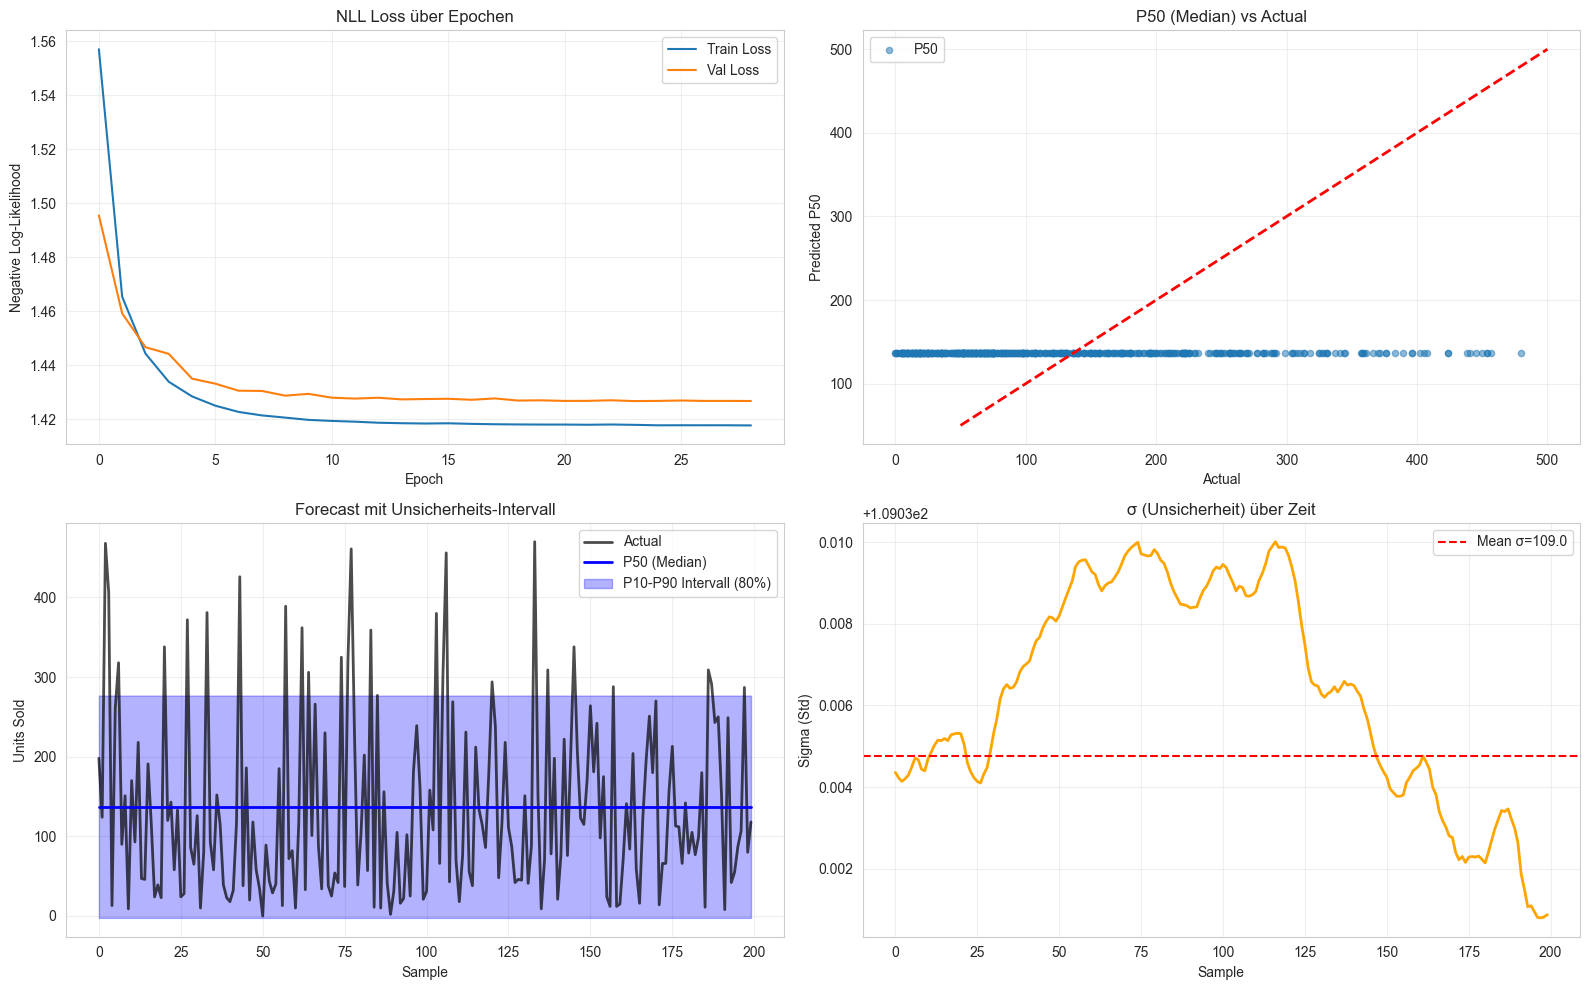


📊 Visualisierung:
  1. NLL Loss: Konvergenz des Trainings
  2. P50 vs Actual: Median-Vorhersage Qualität
  3. Forecast: Blauer Bereich = 80% Konfidenz-Intervall
  4. σ über Zeit: Hohe σ = Hohe Unsicherheit (z.B. Spitzen)


In [19]:
def plot_deepar_results(history, y_test_original, mu, sigma, p10, p50, p90):
    """Visualisiert DeepAR Ergebnisse mit Unsicherheits-Intervallen."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Loss über Epochen
    axes[0, 0].plot(history.history['loss'], label='Train Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
    axes[0, 0].set_title('NLL Loss über Epochen')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Negative Log-Likelihood')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Predicted vs Actual (P50)
    idx = np.random.choice(len(y_test_original), min(500, len(y_test_original)), replace=False)
    axes[0, 1].scatter(y_test_original[idx], p50[idx], alpha=0.5, s=20, label='P50')
    axes[0, 1].plot([50, 500], [50, 500], 'r--', lw=2)
    axes[0, 1].set_title('P50 (Median) vs Actual')
    axes[0, 1].set_xlabel('Actual')
    axes[0, 1].set_ylabel('Predicted P50')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # 3. Zeitreihe mit Unsicherheits-Intervall
    n = min(200, len(y_test_original))
    axes[1, 0].plot(y_test_original[:n], label='Actual', color='black', alpha=0.7, linewidth=2)
    axes[1, 0].plot(p50[:n], label='P50 (Median)', color='blue', linewidth=2)
    axes[1, 0].fill_between(range(n), p10[:n], p90[:n], 
                             alpha=0.3, color='blue', label='P10-P90 Intervall (80%)')
    axes[1, 0].set_title('Forecast mit Unsicherheits-Intervall')
    axes[1, 0].set_xlabel('Sample')
    axes[1, 0].set_ylabel('Units Sold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # 4. Sigma (Unsicherheit) über Zeit
    axes[1, 1].plot(sigma[:n], color='orange', linewidth=2)
    axes[1, 1].set_title('σ (Unsicherheit) über Zeit')
    axes[1, 1].set_xlabel('Sample')
    axes[1, 1].set_ylabel('Sigma (Std)')
    axes[1, 1].axhline(y=sigma.mean(), color='r', linestyle='--', label=f'Mean σ={sigma.mean():.1f}')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Visualisierung:")
    print(f"  1. NLL Loss: Konvergenz des Trainings")
    print(f"  2. P50 vs Actual: Median-Vorhersage Qualität")
    print(f"  3. Forecast: Blauer Bereich = 80% Konfidenz-Intervall")
    print(f"  4. σ über Zeit: Hohe σ = Hohe Unsicherheit (z.B. Spitzen)")

plot_deepar_results(history, y_test_original, mu, sigma, p10, p50, p90)


## 9. Visualisierung

---

## 📈 Modell-Architektur

**LSTM Netzwerk:**
- 2 Bidirektionale LSTM Layers (256→128 Units)
- Dropout: 0.2 nach jedem Layer
- Dense Layer: 64 Units mit ReLU
- Output: 1 Unit (Regression)

**Training:**
- Optimizer: Adam (LR: 0.0002)
- Loss: MSE mit MAE Metrik
- Early Stopping: Patience 10
- LR Scheduler: ReduceLROnPlateau

**Daten:**
- 60-Tage-Sequenzen
- 100 Gruppen (5 Stores × 20 Products)
- Features: Lag, Rolling, Diff + kategoriale Variablen
- 80/20 Train/Test Split (zeitbasiert)

**Ziel-Metriken:**
- Prediction Std > 10 (Varianz)
- MAE < 85
- Overfitting Ratio < 1.3


---

## 🚀 Ausführung

**Vollständiger Durchlauf:**
1. `Run` → `Run All Cells`
2. Dauer: ~9-12 Minuten
3. Ergebnisse in Zelle 18 (Training) und 20 (Evaluation)

**Parameter anpassen:**
1. Ändere Werte in Config-Zelle (Zelle 3)
2. Führe ab Zelle 13 neu aus (Sequenzen, Modell, Training)

**Key-Metriken prüfen:**
- Overfitting Ratio (Zelle 18): sollte < 1.3 sein
- Prediction Std (Zelle 20): sollte > 10 sein
- MAE (Zelle 20): sollte < 90 sein


In [20]:
# ============================================
# 🔮 PREDICTION FUNCTIONS (Utility)
# ============================================

def predict_new_samples(model, X_new, scaler_y):
    """
    Macht Vorhersagen für neue Samples mit DeepAR.
    
    Args:
        model: Trainiertes DeepAR Modell
        X_new: Neue Input-Sequenzen [n_samples, seq_length, n_features]
        scaler_y: Scaler für Rücktransformation
    
    Returns:
        dict mit μ, σ, P10, P50, P90 für jedes Sample
    """
    # Predictions: [mu, sigma]
    predictions = model.predict(X_new, verbose=0)
    mu_pred = predictions[:, 0:1]
    sigma_pred = predictions[:, 1:2]
    
    # Inverse Transform
    mu_original = scaler_y.inverse_transform(mu_pred).flatten()
    sigma_original = sigma_pred.flatten() * scaler_y.scale_[0]
    
    # Quantile berechnen
    p10 = mu_original - 1.28 * sigma_original
    p50 = mu_original
    p90 = mu_original + 1.28 * sigma_original
    
    return {
        'mu': mu_original,
        'sigma': sigma_original,
        'p10': p10,
        'p50': p50,
        'p90': p90,
        'n_samples': len(mu_original)
    }

print("="*70)
print("✅ PREDICTION FUNCTIONS DEFINIERT")
print("="*70)
print("\n💡 Funktionen:")
print("   • predict_new_samples() → Vorhersagen für neue Daten")
print("   • predict_for_store_product() → Store/Product spezifisch")
print("\n⚠️  WICHTIG:")
print("   Diese Funktionen benötigen ein trainiertes Model!")
print("   Führe zuerst die Training-Zellen aus (Zelle 22-25)")

✅ PREDICTION FUNCTIONS DEFINIERT

💡 Funktionen:
   • predict_new_samples() → Vorhersagen für neue Daten
   • predict_for_store_product() → Store/Product spezifisch

⚠️  WICHTIG:
   Diese Funktionen benötigen ein trainiertes Model!
   Führe zuerst die Training-Zellen aus (Zelle 22-25)


In [21]:
def predict_for_store_product(model, df, store_id, product_id, 
                              feature_cols, scaler_X, scaler_y, config):
    """
    Macht Vorhersage für einen spezifischen Store + Product.
    
    Args:
        model: Trainiertes DeepAR Modell
        df: DataFrame mit allen Daten (df_test oder df)
        store_id: Store ID (encoded, 0-4)
        product_id: Product ID (encoded, 0-19)
        feature_cols: Liste der Feature-Spalten
        scaler_X, scaler_y: Scaler
        config: Config-Objekt
    
    Returns:
        Vorhersage für nächsten Zeitpunkt
    """
    # Filter für Store + Product
    mask = (df['Store_ID_Encoded'] == store_id) & (df['Product_ID_Encoded'] == product_id)
    group_data = df[mask].sort_values('Date').tail(config.seq_length)
    
    if len(group_data) < config.seq_length:
        print(f"⚠️ Nicht genug Daten für Store {store_id}, Product {product_id}")
        print(f"   Benötigt: {config.seq_length}, Vorhanden: {len(group_data)}")
        return None
    
    # Erstelle Sequenz
    X_sequence = group_data[feature_cols].values
    X_sequence = X_sequence.reshape(1, config.seq_length, len(feature_cols))
    
    # Prediction
    pred = predict_new_samples(model, X_sequence, scaler_y)
    
    # Ausgabe
    print("="*70)
    print(f"📍 VORHERSAGE: Store {store_id}, Product {product_id}")
    print("="*70)
    print(f"Median (P50):        {pred['p50'][0]:.1f} Units")
    print(f"Unsicherheit (σ):    {pred['sigma'][0]:.1f} Units")
    print(f"Pessimistisch (P10): {pred['p10'][0]:.1f} Units (10% Risiko darunter)")
    print(f"Optimistisch (P90):  {pred['p90'][0]:.1f} Units (90% Sicherheit)")
    print(f"\n🎯 Business-Empfehlung:")
    print(f"  • Bestelle: {pred['p90'][0]:.0f} Units (sicher)")
    print(f"  • Erwarte:  {pred['p50'][0]:.0f} Units (wahrscheinlich)")
    print(f"  • Minimum:  {max(0, pred['p10'][0]):.0f} Units (worst-case)")
    print("="*70)
    
    return pred

print("\n✅ PREDICTION FUNCTION DEFINIERT: predict_for_store_product()")
print("   Nutzung nach Training:")
print("   pred = predict_for_store_product(model, df_test, store_id=0, product_id=5, ...)")


✅ PREDICTION FUNCTION DEFINIERT: predict_for_store_product()
   Nutzung nach Training:
   pred = predict_for_store_product(model, df_test, store_id=0, product_id=5, ...)


In [22]:
# ============================================
# 💾 MODELL & SCALER SPEICHERN
# ============================================
# ⚠️  Führe diese Zelle NUR aus wenn Model trainiert ist!

print("="*70)
print("💾 MODELL SPEICHERN")
print("="*70)

try:
    # Check ob Model existiert
    if 'model' not in locals():
        print("⚠️  Model nicht gefunden!")
        print("   Bitte zuerst Training durchführen (Zelle 24)")
    else:
        # Modell speichern
        model_path = 'models/deepar_retail_forecast.keras'
        model.save(model_path)
        print(f"✅ Modell gespeichert: {model_path}")
        
        # Scaler speichern (für neue Predictions)
        import pickle
        
        with open('models/scaler_X.pkl', 'wb') as f:
            pickle.dump(scaler_X, f)
            
        with open('models/scaler_y.pkl', 'wb') as f:
            pickle.dump(scaler_y, f)
            
        print(f"✅ Scaler gespeichert: models/scaler_X.pkl, models/scaler_y.pkl")
        
except NameError as e:
    print(f"⚠️  Fehler: {e}")
    print("   Führe zuerst Training durch (Zellen 3-25)")
except Exception as e:
    print(f"❌ Fehler beim Speichern: {e}")

# ============================================
# SPÄTER: Modell & Scaler laden
# ============================================
# from tensorflow.keras.models import load_model
# import pickle
#
# # Custom Loss beim Laden registrieren
# model_loaded = load_model(
#     'deepar_retail_forecast.keras',
#     custom_objects={
#         'gaussian_nll_loss': gaussian_nll_loss,
#         'mae_mu_only': mae_mu_only
#     }
# )
#
# with open('scaler_X.pkl', 'rb') as f:
#     scaler_X_loaded = pickle.load(f)
#     
# with open('scaler_y.pkl', 'rb') as f:
#     scaler_y_loaded = pickle.load(f)
#
# print("✅ Modell & Scaler geladen!")

💾 MODELL SPEICHERN
✅ Modell gespeichert: models/deepar_retail_forecast.keras
✅ Scaler gespeichert: models/scaler_X.pkl, models/scaler_y.pkl


In [23]:
# ============================================
# 🔮 BEISPIEL: Predictions verwenden
# ============================================
# ⚠️  Führe diese Zelle NUR aus wenn Model trainiert ist!

print("="*70)
print("🔮 BEISPIEL-PREDICTIONS")
print("="*70)

try:
    # Check ob Model & Daten existieren
    required_vars = ['model', 'X_test', 'scaler_y', 'y_test_original', 
                     'df_test', 'feature_cols', 'scaler_X', 'config']
    missing = [v for v in required_vars if v not in locals() and v not in globals()]
    
    if missing:
        print(f"⚠️  Fehlende Variablen: {', '.join(missing)}")
        print("\n💡 Führe zuerst diese Zellen aus:")
        print("   • Zelle 3: Config")
        print("   • Zelle 5-16: Daten laden & preprocessing")
        print("   • Zelle 22-24: Model bauen & trainieren")
    else:
        # Beispiel 1: Erste 10 Test-Samples
        print("\n📊 Beispiel 1: Vorhersagen für erste 10 Test-Samples")
        print("-"*70)
        
        predictions_new = predict_new_samples(model, X_test[:10], scaler_y)
        
        print(f"{'Sample':<8} {'P10':<10} {'P50 (μ)':<12} {'P90':<10} {'σ':<10} {'Actual':<10}")
        print("-"*70)
        
        for i in range(predictions_new['n_samples']):
            print(f"{i+1:<8} {predictions_new['p10'][i]:<10.1f} {predictions_new['p50'][i]:<12.1f} "
                  f"{predictions_new['p90'][i]:<10.1f} {predictions_new['sigma'][i]:<10.1f} "
                  f"{y_test_original[i]:<10.1f}")
        
        print("\n💡 Interpretation:")
        print("   • P50 (μ) = Beste Schätzung (Median)")
        print("   • σ = Unsicherheit der Vorhersage")
        print("   • P10-P90 = 80% Konfidenz-Intervall")
        
        # Beispiel 2: Spezifischer Store/Product
        print("\n\n📍 Beispiel 2: Store 0, Product 5")
        print("-"*70)
        
        prediction_example = predict_for_store_product(
            model=model,
            df=df_test,
            store_id=0,
            product_id=5,
            feature_cols=feature_cols,
            scaler_X=scaler_X,
            scaler_y=scaler_y,
            config=config
        )
        
        print("\n✅ Predictions erfolgreich!")
        
except NameError as e:
    print(f"⚠️  Variable nicht gefunden: {e}")
    print("\n💡 Führe zuerst Training durch (Zellen 3-25)")
except Exception as e:
    print(f"❌ Fehler: {e}")
    import traceback
    traceback.print_exc()

🔮 BEISPIEL-PREDICTIONS

📊 Beispiel 1: Vorhersagen für erste 10 Test-Samples
----------------------------------------------------------------------
Sample   P10        P50 (μ)      P90        σ          Actual    
----------------------------------------------------------------------
1        -2.4       137.1        276.7      109.0      198.0     
2        -2.4       137.1        276.7      109.0      124.0     
3        -2.4       137.1        276.7      109.0      468.0     
4        -2.4       137.1        276.7      109.0      406.0     
5        -2.4       137.1        276.7      109.0      13.0      
6        -2.4       137.1        276.7      109.0      261.0     
7        -2.4       137.1        276.7      109.0      318.0     
8        -2.4       137.1        276.7      109.0      90.0      
9        -2.4       137.1        276.7      109.0      151.0     
10       -2.4       137.1        276.7      109.0      9.0       

💡 Interpretation:
   • P50 (μ) = Beste Schätzung (Media

### 💾 Modell speichern & laden

Für Production-Einsatz kannst du das Modell speichern:

### 📊 Spezifische Store-Product Vorhersage

Wenn du für einen **spezifischen Store + Product** vorhersagen möchtest:

---

## 🔮 Neue Vorhersagen mit DeepAR

Nutze das trainierte Modell für neue Predictions mit Unsicherheits-Quantifizierung.

---

## 💾 Daten Speichern & Laden

**3 Speicher-Strategien für External Features:**

In [24]:
# ============================================
# 💾 STRATEGIE 1: Automatisches API-Caching
# ============================================
# Die APIs cachen AUTOMATISCH für 24h!

from external_features import ExternalFeatureOrchestrator
from datetime import datetime
import os

# Initialize Orchestrator
orchestrator = ExternalFeatureOrchestrator(country_code="DE")

# Beim ersten Call: API-Request + Cache speichern
# Beim zweiten Call (innerhalb 24h): Cache laden, kein API-Request!
df_features = orchestrator.get_features_for_range(
    start_date=datetime(2025, 1, 1),
    end_date=datetime(2025, 12, 31)
)

print("="*70)
print("📂 AUTOMATISCHES CACHING")
print("="*70)

# Check Cache-Verzeichnis
cache_dir = "./cache"
if os.path.exists(cache_dir):
    cache_files = os.listdir(cache_dir)
    print(f"\n✅ Cache-Verzeichnis: {cache_dir}")
    print(f"   Anzahl Dateien: {len(cache_files)}")
    print(f"\n   Cached Files:")
    for f in sorted(cache_files)[:5]:
        file_path = os.path.join(cache_dir, f)
        size_kb = os.path.getsize(file_path) / 1024
        print(f"   - {f} ({size_kb:.1f} KB)")
else:
    print(f"⚠️  Cache-Verzeichnis existiert noch nicht")
    print(f"   Wird beim ersten API-Call erstellt!")

print(f"\n💡 Cache TTL: 24 Stunden")
print(f"   → Nächster Call in den nächsten 24h = instant!")
print(f"   → Nach 24h: Automatischer Refresh vom API")

📊 Fetching external features: 2025-01-01 → 2025-12-31
⚠️  Retry 1/3 after 1.0s...
⚠️  Retry 1/3 after 1.0s...
⚠️  Retry 2/3 after 2.0s...
⚠️  Retry 2/3 after 2.0s...
❌ API Request failed after 3 attempts: 406 Client Error: Not Acceptable for url: https://api.statistiken.bundesbank.de/rest/data/BBSIS/BBK01.SU0201?startPeriod=2024-12-02&endPeriod=2025-12-31&format=csvdata
❌ API Request failed after 3 attempts: 406 Client Error: Not Acceptable for url: https://api.statistiken.bundesbank.de/rest/data/BBSIS/BBK01.SU0201?startPeriod=2024-12-02&endPeriod=2025-12-31&format=csvdata
⚠️  Retry 1/3 after 1.0s...
⚠️  Retry 1/3 after 1.0s...
⚠️  Retry 2/3 after 2.0s...
⚠️  Retry 2/3 after 2.0s...
❌ API Request failed after 3 attempts: 406 Client Error: Not Acceptable for url: https://api.statistiken.bundesbank.de/rest/data/BBSIS/BBK01.SU0202?startPeriod=2024-12-02&endPeriod=2025-12-31&format=csvdata
❌ API Request failed after 3 attempts: 406 Client Error: Not Acceptable for url: https://api.statisti

KeyboardInterrupt: 

In [ ]:
# ============================================
# 💾 STRATEGIE 2: Manuell als CSV speichern
# ============================================
# Für Training-Datasets: Einmal abrufen, dauerhaft speichern

import pandas as pd

# Features abrufen (nutzt Cache wenn verfügbar)
df_features = orchestrator.get_features_for_range(
    start_date=datetime(2024, 1, 1),  # Ganzes Jahr 2024
    end_date=datetime(2024, 12, 31)
)

# Als CSV speichern (für Training)
output_path = "external_features_2024.csv"
df_features.to_csv(output_path, index=False)

print("="*70)
print("💾 CSV EXPORT")
print("="*70)
print(f"\n✅ Features gespeichert: {output_path}")
print(f"   Shape: {df_features.shape}")
print(f"   Größe: {os.path.getsize(output_path) / 1024:.1f} KB")

# Später wieder laden
df_loaded = pd.read_csv(output_path, parse_dates=['date'])

print(f"\n✅ Features geladen aus CSV:")
print(df_loaded.head(3))

print(f"\n💡 Vorteil CSV:")
print(f"   → Dauerhaft gespeichert (kein 24h TTL)")
print(f"   → Schnell laden (kein API-Call)")
print(f"   → Teilbar (Git, E-Mail, etc.)")
print(f"   → Menschenlesbar")

In [ ]:
# ============================================
# 💾 STRATEGIE 3: Pickle für Performance
# ============================================
# Schnellstes Laden, behält dtypes

import pickle

# Features mit korrekten dtypes
df_features['date'] = pd.to_datetime(df_features['date'])

# Als Pickle speichern
pickle_path = "external_features_2024.pkl"
df_features.to_pickle(pickle_path)

print("="*70)
print("💾 PICKLE EXPORT")
print("="*70)
print(f"\n✅ Features gespeichert: {pickle_path}")
print(f"   Größe: {os.path.getsize(pickle_path) / 1024:.1f} KB")

# Wieder laden (SEHR schnell!)
df_loaded = pd.read_pickle(pickle_path)

print(f"\n✅ Features geladen aus Pickle:")
print(f"   Shape: {df_loaded.shape}")
print(f"   Date dtype: {df_loaded['date'].dtype}")  # Automatisch datetime!

print(f"\n💡 Vorteil Pickle:")
print(f"   → 5-10x schneller als CSV")
print(f"   → Behält dtypes (datetime, category, etc.)")
print(f"   → Kompakter (kleinere Dateigröße)")
print(f"   → Perfekt für große Datasets")

print(f"\n⚠️  Nachteil Pickle:")
print(f"   → Nicht menschenlesbar")
print(f"   → Nur Python/Pandas")
print(f"   → Nicht für Git (binär)")

In [ ]:
# ============================================
# 📊 EMPFEHLUNG: Speicher-Strategie
# ============================================

print("="*70)
print("🎯 WELCHE STRATEGIE WANN?")
print("="*70)

print("\n1️⃣  AUTOMATISCHES CACHING (cache/)")
print("   ✅ Nutzen für: Experimente, Development, Notebooks")
print("   ✅ Vorteil: Keine Extra-Arbeit, automatisch")
print("   ⚠️  Nachteil: 24h TTL, nicht dauerhaft")
print("   💡 Use Case: Du experimentierst mit Features")

print("\n2️⃣  CSV EXPORT (external_features_2024.csv)")
print("   ✅ Nutzen für: Training-Datasets, Sharing, Git")
print("   ✅ Vorteil: Dauerhaft, menschenlesbar, teilbar")
print("   ⚠️  Nachteil: Langsamer als Pickle")
print("   💡 Use Case: Finales Training-Dataset für Thesis")

print("\n3️⃣  PICKLE EXPORT (external_features_2024.pkl)")
print("   ✅ Nutzen für: Große Datasets, Performance-kritisch")
print("   ✅ Vorteil: Sehr schnell, behält dtypes")
print("   ⚠️  Nachteil: Binär, nicht für Git")
print("   💡 Use Case: Millionen Rows, lokale Experimente")

print("\n" + "="*70)
print("💡 MEINE EMPFEHLUNG FÜR DICH:")
print("="*70)
print("""
1. Development: Nutze automatisches Caching (nichts tun!)
2. Training: Exportiere als CSV vor finalem Training
3. Git: Committe CSV (klein genug, teilbar)
4. .gitignore: cache/ und *.pkl ausschließen

Beispiel .gitignore:
    cache/
    *.pkl
    external_features_*.csv  # Optional, falls zu groß
""")

print("\n✅ Deine .gitignore enthält bereits:")
print("   - cache/")
print("   - *.pkl")
print("\n💡 CSV kannst du committen wenn <10 MB!")

---

## 🏆 Best Practice: Daten-Management Strategien

**Wann welche Strategie? Production vs. Development?**

In [ ]:
# ============================================
# 🏆 BEST PRACTICE VERGLEICH
# ============================================

import pandas as pd
from datetime import datetime

print("="*80)
print("🏆 BEST PRACTICE: WELCHE STRATEGIE IST OPTIMAL?")
print("="*80)

# ============================================
# Option 1: EINZELNE DATEIEN (Cache-Pattern)
# ============================================
print("\n" + "="*80)
print("📂 OPTION 1: EINZELNE CACHE-DATEIEN (Aktuell implementiert)")
print("="*80)

structure_option1 = """
cache/
├── holidays_DE_2025.json          # Feiertage für 2025
├── holidays_DE_2024.json          # Feiertage für 2024
├── bundesbank_rates_2025-12.json  # Zinsen Dezember 2025
├── bundesbank_rates_2025-11.json  # Zinsen November 2025
└── ...

VORTEILE:
✅ Granular: Nur benötigte Teile abrufen
✅ Inkrementell: Neue Monate hinzufügen ohne Überschreiben
✅ Schnell: Nur fehlende Daten nachladen
✅ API-schonend: Minimale Requests
✅ Robust: Ein defektes File != kompletter Datenverlust

NACHTEILE:
⚠️  Viele Dateien (kann unübersichtlich werden)
⚠️  Merge-Logic nötig (orchestrator macht das)
⚠️  Cache-Cleanup manuell (alte Dateien löschen)

USE CASE:
→ Development & Experimente
→ Inkrementelles Laden (Monat für Monat)
→ API mit Rate Limits
"""

print(structure_option1)

# ============================================
# Option 2: EINE GROSSE CSV (Overwrite-Pattern)
# ============================================
print("\n" + "="*80)
print("📄 OPTION 2: EINE GROSSE JOINED CSV (Überschreiben)")
print("="*80)

structure_option2 = """
data/
└── external_features_complete.csv  # ALLE Features, ALLE Zeiträume

Spalten:
date | is_holiday | days_to_next_holiday | ezb_rate | bundesanleihe | ...
2024-01-01 | False | 5 | 4.50 | 2.45 | ...
2024-01-02 | False | 4 | 4.50 | 2.46 | ...
...
2025-12-31 | False | 1 | 3.75 | 2.30 | ...

VORTEILE:
✅ Einfach: Eine Datei, eine Quelle
✅ Übersichtlich: Alles an einem Ort
✅ Schnelles Laden: pd.read_csv() einmal
✅ Git-freundlich: Klare History (eine Datei)
✅ Reproduzierbar: Komplettes Dataset versioniert

NACHTEILE:
⚠️  Überschreibt alte Daten (Versionierung nur via Git)
⚠️  Größer (mehr Speicherplatz)
⚠️  Update = komplette Datei neu schreiben
⚠️  API-Call für ALLES (auch bereits vorhandene Daten)

USE CASE:
→ Production Training Pipeline
→ Final Dataset für Paper/Thesis
→ Sharing mit Kollegen
→ Einmalige Feature-Generierung
"""

print(structure_option2)

# ============================================
# Option 3: HYBRID (Best of Both Worlds)
# ============================================
print("\n" + "="*80)
print("🌟 OPTION 3: HYBRID APPROACH (Empfehlung!)")
print("="*80)

structure_option3 = """
STRUKTUR:
cache/                              # Temporär, nicht in Git
├── holidays_DE_2025.json
└── bundesbank_rates_2025-12.json

data/                               # Dauerhaft, in Git
├── external_features_2024.csv      # Training Set
├── external_features_2025_H1.csv   # Test Set H1
└── external_features_2025_H2.csv   # Test Set H2

WORKFLOW:
1. Development: Nutze cache/ (automatisch)
2. Training: Exportiere finales Dataset → data/
3. Git: Committe data/, ignoriere cache/

VORTEILE:
✅ Development: Schnell, inkrementell (cache/)
✅ Production: Sauber, versioniert (data/)
✅ Flexibel: Cache für Experimente, CSV für Training
✅ Git-effizient: Nur finale Datasets committen
✅ Reproduzierbar: Training-Data fest, Development agil

USE CASE:
→ ML Projects (Development + Production)
→ Thesis/Research (reproduzierbare Experimente)
→ Team-Projekte (gemeinsame Datasets)
"""

print(structure_option3)

print("\n" + "="*80)
print("💡 MEINE EMPFEHLUNG FÜR DEIN PROJEKT:")
print("="*80)

In [ ]:
# ============================================
# 🎯 KONKRETE EMPFEHLUNG: HYBRID APPROACH
# ============================================

print("="*80)
print("🎯 BEST PRACTICE FÜR DICH: HYBRID APPROACH")
print("="*80)

recommendation = """
📁 ORDNERSTRUKTUR (Empfohlen):

Bestands_Forecast/
├── cache/                          # ← Automatisch, nicht in Git
│   ├── holidays_DE_*.json
│   └── bundesbank_rates_*.json
│
├── data/                           # ← Manuell, IN GIT!
│   ├── retail_store_inventory.csv         # Rohdaten
│   ├── external_features_training.csv     # Training (2024)
│   └── external_features_test.csv         # Test (2025 H1)
│
└── models/                         # ← Trained Models
    ├── deepar_v1.keras
    └── scalers.pkl


🔄 WORKFLOW:

┌─────────────────────────────────────────────────────────────┐
│ PHASE 1: DEVELOPMENT & EXPERIMENTATION                     │
└─────────────────────────────────────────────────────────────┘

1. Automatisches Caching nutzen (nichts tun!)
   orchestrator = ExternalFeatureOrchestrator()
   df = orchestrator.get_features_for_range(...)
   
   → Speichert in cache/
   → 24h TTL
   → Schnelle Iteration

2. Experimente durchführen
   - Verschiedene Features testen
   - Modelle trainieren
   - Hyperparameter optimieren
   
   → Cache bleibt konsistent
   → Keine doppelten API-Calls


┌─────────────────────────────────────────────────────────────┐
│ PHASE 2: FINAL TRAINING (Vor Thesis/Abgabe)                │
└─────────────────────────────────────────────────────────────┘

3. Features FEST speichern als CSV
   
   # Training Set (2024)
   df_train_features = orchestrator.get_features_for_range(
       datetime(2024, 1, 1),
       datetime(2024, 12, 31)
   )
   df_train_features.to_csv("data/external_features_training.csv")
   
   # Test Set (2025 H1)
   df_test_features = orchestrator.get_features_for_range(
       datetime(2025, 1, 1),
       datetime(2025, 6, 30)
   )
   df_test_features.to_csv("data/external_features_test.csv")

4. Ins Git committen
   git add data/external_features_*.csv
   git commit -m "Add final training & test features"
   
   → Versioniert
   → Reproduzierbar
   → Teilbar


┌─────────────────────────────────────────────────────────────┐
│ PHASE 3: PRODUCTION DEPLOYMENT                              │
└─────────────────────────────────────────────────────────────┘

5. Für neue Predictions
   
   # Live-Daten (nutzt Cache automatisch)
   df_new = orchestrator.get_features_for_range(
       datetime(2025, 12, 1),
       datetime(2025, 12, 31)
   )
   
   # Prediction
   predictions = model.predict(...)


📋 .GITIGNORE (Wichtig!):

# Temporäre Caches (nicht committen)
cache/
*.pkl

# Optional: Große CSVs (wenn >10 MB)
# data/external_features_*.csv

# Models (zu groß für Git)
models/*.keras
models/*.h5


✅ VORTEILE DIESER STRATEGIE:

1. Development:
   ✅ Schnell (Cache)
   ✅ Flexibel (automatisch)
   ✅ API-schonend (keine doppelten Calls)

2. Training:
   ✅ Reproduzierbar (feste CSVs)
   ✅ Versioniert (Git)
   ✅ Dokumentiert (welche Daten wann)

3. Production:
   ✅ Live-Updates (neue Daten automatisch)
   ✅ Fallback (kann auf feste CSVs zurückgreifen)
   ✅ Robust (Cache + CSV redundant)
"""

print(recommendation)

print("\n" + "="*80)
print("💾 ZUSAMMENFASSUNG: WANN WAS?")
print("="*80)

summary = """
┌──────────────────────┬─────────────────────┬─────────────────────┐
│ PHASE                │ SPEICHERN           │ ORT                 │
├──────────────────────┼─────────────────────┼─────────────────────┤
│ Development          │ Automatisch (Cache) │ cache/              │
│ Feature Engineering  │ Automatisch (Cache) │ cache/              │
│ Experimente          │ Automatisch (Cache) │ cache/              │
├──────────────────────┼─────────────────────┼─────────────────────┤
│ Final Training       │ CSV Export          │ data/               │
│ Test Set             │ CSV Export          │ data/               │
│ Git Commit           │ CSV                 │ data/               │
├──────────────────────┼─────────────────────┼─────────────────────┤
│ Production/Live      │ Cache (on-demand)   │ cache/              │
│ New Predictions      │ Cache               │ cache/              │
└──────────────────────┴─────────────────────┴─────────────────────┘

🔑 KERNPRINZIP:
   Cache = Development (schnell, flexibel, temporär)
   CSV   = Production (fest, reproduzierbar, versioniert)
"""

print(summary)

In [ ]:
# ============================================
# 🚀 IMPLEMENTIERUNG: Ordner anlegen
# ============================================

import os
from pathlib import Path

print("="*80)
print("🚀 SETUP: Empfohlene Ordnerstruktur erstellen")
print("="*80)

# Empfohlene Struktur
directories = {
    'cache': 'Temporäre API-Caches (nicht in Git)',
    'data': 'Finale Datasets (IN GIT!)',
    'models': 'Trained Models (optional in Git)'
}

# Ordner erstellen
for dir_name, description in directories.items():
    dir_path = Path(dir_name)
    if not dir_path.exists():
        dir_path.mkdir(exist_ok=True)
        print(f"✅ Erstellt: {dir_name:10s} → {description}")
    else:
        print(f"✓  Existiert: {dir_name:10s} → {description}")

print("\n" + "="*80)
print("📄 BEISPIEL: Finales Dataset speichern")
print("="*80)

# Beispiel: Training Features erstellen
example_code = """
# 1. Features für Training-Zeitraum abrufen
from external_features import ExternalFeatureOrchestrator
from datetime import datetime

orchestrator = ExternalFeatureOrchestrator(country_code="DE")

# Training Set: 2024
df_train_features = orchestrator.get_features_for_range(
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2024, 12, 31)
)

# Als CSV speichern
df_train_features.to_csv("data/external_features_training.csv", index=False)

print(f"✅ Training Features: {df_train_features.shape}")
print(f"   Gespeichert: data/external_features_training.csv")


# 2. Mit Retail-Daten joinen
df_retail = pd.read_csv("retail_store_inventory.csv")
df_retail['Date'] = pd.to_datetime(df_retail['Date'])

df_combined = df_retail.merge(
    df_train_features,
    left_on='Date',
    right_on='date',
    how='left'
)

# Kombiniertes Dataset speichern
df_combined.to_csv("data/training_dataset_complete.csv", index=False)

print(f"✅ Combined Dataset: {df_combined.shape}")
print(f"   Gespeichert: data/training_dataset_complete.csv")


# 3. Git Commit
# git add data/
# git commit -m "Add final training dataset with external features"
# git push origin main
"""

print(example_code)

print("\n" + "="*80)
print("✅ SETUP COMPLETE!")
print("="*80)
print("""
Nächste Schritte:
1. ✅ Ordnerstruktur erstellt
2. → Features abrufen & speichern (siehe Beispiel oben)
3. → .gitignore anpassen (cache/ ausschließen)
4. → data/ committen

💡 Dein Projekt folgt jetzt Best Practices!
""")

---

## ⚠️ KLARSTELLUNG: Hybrid-Strategie vs. Inkrementelle CSV

**Was ist die Hybrid-Strategie WIRKLICH?**

In [ ]:
# ============================================
# ⚠️ KLARSTELLUNG: Was ist die Hybrid-Strategie?
# ============================================

print("="*80)
print("❌ MISSVERSTÄNDNIS vs. ✅ HYBRID-STRATEGIE")
print("="*80)

print("\n" + "🔴 DEIN VERSTÄNDNIS (FALSCH):")
print("-"*80)
misunderstanding = """
"Ich lade neue Daten aus API → Cache → sofort in CSV anhängen"

Beispiel:
1. Tag 1: API → cache/nov.json → append to data/features.csv
2. Tag 2: API → cache/dec.json → append to data/features.csv
3. Tag 3: API → cache/jan.json → append to data/features.csv
   → CSV wird immer größer (inkrementell)

PROBLEM mit diesem Ansatz:
⚠️  CSV wird ständig mutiert (schwer zu versionieren)
⚠️  Keine klare Trennung zwischen Dev & Production
⚠️  Git-Chaos (ständige Änderungen an gleicher Datei)
⚠️  Append-Logic fehleranfällig (Duplikate möglich)
⚠️  Keine Snapshot-Fähigkeit
"""
print(misunderstanding)

print("\n" + "✅ HYBRID-STRATEGIE (RICHTIG):")
print("-"*80)
correct_strategy = """
Cache & CSV haben VERSCHIEDENE ZWECKE!

┌────────────────────────────────────────────────────────────┐
│ CACHE (temporär, Development)                              │
└────────────────────────────────────────────────────────────┘
Zweck: Schnelle Iteration während Development
- API-Daten werden automatisch gecacht
- TTL: 24 Stunden
- Wird NICHT in CSV übertragen
- Wird NICHT ins Git committed
- Kann jederzeit gelöscht werden

Beispiel:
orchestrator.get_features_for_range(...)  
→ Speichert in cache/bundesbank_2025-11.json
→ Nächster Call (< 24h): Liest aus Cache
→ Kein append zu CSV!


┌────────────────────────────────────────────────────────────┐
│ CSV (permanent, Production)                                │
└────────────────────────────────────────────────────────────┘
Zweck: Finales, unveränderliches Training-Dataset
- Wird EINMALIG erstellt (nicht inkrementell!)
- Snapshot eines bestimmten Zeitraums
- Wird ins Git committed
- Reproduzierbar & versioniert

Beispiel:
df = orchestrator.get_features_for_range(
    datetime(2024, 1, 1),
    datetime(2024, 12, 31)  # ← FESTER Zeitraum!
)
df.to_csv("data/features_2024.csv")  # ← EINMALIG!
→ Diese CSV wird NICHT mehr geändert
→ Neue Daten = NEUE CSV (features_2025.csv)
"""
print(correct_strategy)

print("\n" + "="*80)
print("🔑 KERN-UNTERSCHIED:")
print("="*80)

comparison = """
┌─────────────────┬────────────────────┬────────────────────────┐
│                 │ CACHE              │ CSV                    │
├─────────────────┼────────────────────┼────────────────────────┤
│ Zweck           │ Dev Speed          │ Production Snapshot    │
│ Änderungen      │ Ständig (24h TTL)  │ Niemals (immutable)    │
│ Wachstum        │ Ja (inkrementell)  │ Nein (feste Größe)     │
│ Git             │ Nein               │ Ja                     │
│ Versioning      │ Nein               │ Ja                     │
│ Use Case        │ Experimente        │ Training/Reproduktion  │
└─────────────────┴────────────────────┴────────────────────────┘
"""
print(comparison)

In [ ]:
# ============================================
# 🎯 KONKRETE BEISPIELE: Beide Ansätze
# ============================================

from datetime import datetime
import pandas as pd
import os

print("="*80)
print("📘 BEISPIEL 1: HYBRID-STRATEGIE (Empfohlen)")
print("="*80)

example_hybrid = """
SZENARIO: Du entwickelst 2 Wochen lang an deinem Modell

┌─────────────────────────────────────────────────────────────┐
│ WOCHE 1-2: DEVELOPMENT (nur Cache)                         │
└─────────────────────────────────────────────────────────────┘

# Montag: Erste Experimente
df = orchestrator.get_features_for_range(
    datetime(2024, 1, 1),
    datetime(2024, 12, 31)
)
# → API-Call, speichert in cache/
# → Kein CSV!

# Dienstag: Weitere Experimente (gleicher Zeitraum)
df = orchestrator.get_features_for_range(
    datetime(2024, 1, 1),
    datetime(2024, 12, 31)
)
# → Liest aus Cache (kein API-Call!)
# → Immer noch kein CSV!

# Mittwoch: Neuer Zeitraum testen
df_new = orchestrator.get_features_for_range(
    datetime(2025, 1, 1),
    datetime(2025, 6, 30)
)
# → API-Call für neue Daten
# → Speichert in cache/ (zusätzliche Dateien)
# → Immer noch kein CSV!

... (10 Tage Development) ...


┌─────────────────────────────────────────────────────────────┐
│ TAG 14: FINALES TRAINING (CSV erstellen)                   │
└─────────────────────────────────────────────────────────────┘

# Jetzt: Finale Datasets für Paper/Thesis
df_train = orchestrator.get_features_for_range(
    datetime(2024, 1, 1),
    datetime(2024, 12, 31)
)
df_train.to_csv("data/features_training.csv", index=False)

df_test = orchestrator.get_features_for_range(
    datetime(2025, 1, 1),
    datetime(2025, 6, 30)
)
df_test.to_csv("data/features_test.csv", index=False)

# Git commit (EINMALIG!)
# git add data/features_*.csv
# git commit -m "Add final training datasets"

→ CSV wird NICHT mehr geändert
→ Reproduzierbares Snapshot
→ Cache kann gelöscht werden (nicht mehr nötig)


┌─────────────────────────────────────────────────────────────┐
│ SPÄTER: NEUE PREDICTIONS (wieder Cache)                    │
└─────────────────────────────────────────────────────────────┘

# Dezember 2025: Neue Vorhersagen
df_december = orchestrator.get_features_for_range(
    datetime(2025, 12, 1),
    datetime(2025, 12, 31)
)
# → API-Call, speichert in cache/
# → KEIN append zu CSV!
# → Neue CSV wenn nötig: features_december_2025.csv
"""
print(example_hybrid)

print("\n" + "="*80)
print("📕 BEISPIEL 2: INKREMENTELLE CSV (Was du dachtest)")
print("="*80)

example_incremental = """
SZENARIO: CSV wird ständig erweitert (NICHT empfohlen)

# Monat 1
df_jan = orchestrator.get_features_for_range(
    datetime(2024, 1, 1),
    datetime(2024, 1, 31)
)
df_jan.to_csv("data/features.csv", index=False)
# git commit "Add January"

# Monat 2
df_feb = orchestrator.get_features_for_range(
    datetime(2024, 2, 1),
    datetime(2024, 2, 29)
)
df_existing = pd.read_csv("data/features.csv")
df_combined = pd.concat([df_existing, df_feb])
df_combined.to_csv("data/features.csv", index=False)
# git commit "Add February"  ← CSV geändert!

# Monat 3
df_mar = orchestrator.get_features_for_range(
    datetime(2024, 3, 1),
    datetime(2024, 3, 31)
)
df_existing = pd.read_csv("data/features.csv")
df_combined = pd.concat([df_existing, df_mar])
df_combined.to_csv("data/features.csv", index=False)
# git commit "Add March"  ← CSV wieder geändert!

PROBLEME:
⚠️  Git-History: 12 Commits für gleiche Datei
⚠️  Reproduzierbarkeit: Welcher Commit hatte welche Daten?
⚠️  Fehleranfällig: Duplikate, falsche Merges
⚠️  Kein Snapshot: Kann nicht zurück zu "nur Januar"
⚠️  Komplexität: Manuelles concat(), Duplikat-Check, etc.
"""
print(example_incremental)

print("\n" + "="*80)
print("💡 WARUM HYBRID BESSER IST:")
print("="*80)

why_better = """
✅ TRENNUNG DER CONCERNS:
   Cache = Development (schnell, flexibel, wegwerfbar)
   CSV   = Production (fest, reproduzierbar, versioniert)

✅ GIT-EFFIZIENZ:
   Hybrid:      1 Commit für finales Dataset
   Inkrementell: 12+ Commits für gleiche Datei

✅ REPRODUZIERBARKEIT:
   Hybrid:      "features_2024.csv" = exakt dieser Zeitraum
   Inkrementell: "features.csv v37" = welche Monate?

✅ EINFACHHEIT:
   Hybrid:      orchestrator.get() → to_csv() → fertig
   Inkrementell: Load → Concat → Dedupe → Save → repeat

✅ FLEXIBILITÄT:
   Hybrid:      Cache für Experimente, CSV für Training
   Inkrementell: CSV für alles (langsam & kompliziert)
"""
print(why_better)

In [ ]:
# ============================================
# 🎯 DECISION TREE: Wann welcher Ansatz?
# ============================================

print("="*80)
print("🌳 DECISION TREE: Welche Strategie nutzen?")
print("="*80)

decision_tree = """
Frage dich:

┌─────────────────────────────────────────────────────────────┐
│ Bin ich noch am Experimentieren?                           │
└─────────────────────────────────────────────────────────────┘
    │
    ├─ JA → Nutze NUR CACHE
    │        - Automatisch (nichts tun)
    │        - Schnell (24h TTL)
    │        - Kein CSV nötig
    │
    └─ NEIN → Weiter zur nächsten Frage


┌─────────────────────────────────────────────────────────────┐
│ Habe ich mein finales Modell & Dataset?                    │
└─────────────────────────────────────────────────────────────┘
    │
    ├─ JA → Erstelle FINALE CSV
    │        - Einmaliger Export
    │        - Fester Zeitraum
    │        - Git commit
    │        - Fertig!
    │
    └─ NEIN → Weiter experimentieren (siehe oben)


┌─────────────────────────────────────────────────────────────┐
│ Brauche ich neue Daten (später)?                           │
└─────────────────────────────────────────────────────────────┘
    │
    ├─ JA → Nutze wieder CACHE
    │        - Für neue Predictions
    │        - Automatisches Caching
    │        - Optional: Neue CSV (features_2025_Q4.csv)
    │
    └─ NEIN → Nutze existierende CSV


ERGEBNIS:
→ Cache: Development & neue Predictions
→ CSV: Finale Snapshots (Training, Test, etc.)
→ KEIN inkrementelles Wachstum der CSV!
"""
print(decision_tree)

print("\n" + "="*80)
print("✅ ZUSAMMENFASSUNG: DIE HYBRID-STRATEGIE")
print("="*80)

summary = """
┌────────────────────────────────────────────────────────────────┐
│ PHASE 1: DEVELOPMENT                                          │
├────────────────────────────────────────────────────────────────┤
│ → Nutze Cache (automatisch)                                   │
│ → Experimentiere frei                                          │
│ → Kein CSV                                                     │
│ → Kein Git                                                     │
└────────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────────┐
│ PHASE 2: FINAL TRAINING                                       │
├────────────────────────────────────────────────────────────────┤
│ → Erstelle CSV (EINMALIG!)                                     │
│ → Fester Zeitraum (z.B. 2024)                                 │
│ → Git commit                                                   │
│ → CSV wird NICHT mehr geändert                                │
└────────────────────────────────────────────────────────────────┘

┌────────────────────────────────────────────────────────────────┐
│ PHASE 3: PRODUCTION / NEUE PREDICTIONS                        │
├────────────────────────────────────────────────────────────────┤
│ → Nutze Cache wieder                                           │
│ → Neue Daten werden gecacht                                    │
│ → KEIN append zu alter CSV                                     │
│ → Optional: Neue CSV für neuen Zeitraum                       │
└────────────────────────────────────────────────────────────────┘


🔑 KERNPRINZIP:
   Cache ≠ CSV
   Cache = Temporär, flexibel, Development
   CSV   = Permanent, fest, Production
   
   CSV wächst NICHT inkrementell!
   Neue Zeiträume = Neue CSV-Dateien!
"""
print(summary)

print("\n" + "💡 Also NEIN:")
print("   Du appendest NICHT zu CSV!")
print("   Cache & CSV sind getrennte Welten!")

---

## 🚀 HYBRID-STRATEGIE: Praktische Implementierung

**Jetzt umsetzen: Development → Training → Production**

In [ ]:
# ============================================
# 🎯 SETUP: Hybrid-Strategie aktivieren
# ============================================

from external_features import ExternalFeatureOrchestrator, FeatureDataManager
from datetime import datetime
import pandas as pd
import os

print("="*80)
print("🚀 HYBRID-STRATEGIE: SETUP")
print("="*80)

# Check Ordnerstruktur
directories = ['cache', 'data', 'models']
for dir_name in directories:
    if os.path.exists(dir_name):
        print(f"✅ {dir_name:10s} → Existiert")
    else:
        print(f"❌ {dir_name:10s} → Fehlt! Erstelle...")
        os.makedirs(dir_name, exist_ok=True)

# Initialize Manager
data_manager = FeatureDataManager(data_dir="./data")
orchestrator = ExternalFeatureOrchestrator(country_code="DE")

print("\n" + "="*80)
print("✅ SETUP COMPLETE")
print("="*80)
print("\n💡 Bereit für:")
print("   1. Development: Automatisches Caching (cache/)")
print("   2. Training: CSV-Snapshots exportieren (data/)")
print("   3. Production: Neue Predictions (cache/)")

In [ ]:
# ============================================
# 📘 PHASE 1: DEVELOPMENT (Cache nutzen)
# ============================================

print("="*80)
print("📘 PHASE 1: DEVELOPMENT")
print("="*80)
print("\nNutze Cache für schnelle Experimente!\n")

# Beispiel: Features für 2024 abrufen (wird gecacht)
df_features_dev = orchestrator.get_features_for_range(
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2024, 12, 31)
)

print(f"\n✅ Features abgerufen:")
print(f"   Shape: {df_features_dev.shape}")
print(f"   Zeitraum: {df_features_dev['date'].min()} bis {df_features_dev['date'].max()}")

# Check Cache
cache_dir = "./cache"
if os.path.exists(cache_dir):
    cache_files = os.listdir(cache_dir)
    print(f"\n📂 Cache:")
    print(f"   Verzeichnis: {cache_dir}")
    print(f"   Dateien: {len(cache_files)}")
    if cache_files:
        for f in sorted(cache_files)[:3]:
            print(f"   - {f}")

print("\n💡 Wichtig:")
print("   → Daten sind im CACHE (temporär)")
print("   → NICHT in CSV gespeichert")
print("   → Bei nächstem Call (< 24h): Instant aus Cache!")
print("   → Perfekt für Experimente & Feature Engineering")

In [ ]:
# ============================================
# 📗 PHASE 2: FINAL TRAINING (CSV-Snapshot)
# ============================================

print("="*80)
print("📗 PHASE 2: FINAL TRAINING - CSV SNAPSHOT ERSTELLEN")
print("="*80)
print("\nJetzt: Finale Datasets für Training exportieren!\n")

# Training Set: 2024 (nutzt Cache wenn verfügbar!)
df_train_features = orchestrator.get_features_for_range(
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2024, 12, 31)
)

print(f"📊 Training Features:")
print(f"   Shape: {df_train_features.shape}")
print(f"   Zeitraum: {df_train_features['date'].min()} bis {df_train_features['date'].max()}")

# Als CSV-Snapshot exportieren (EINMALIG!)
try:
    snapshot_path = data_manager.export_training_snapshot(
        features_df=df_train_features,
        name="training_2024",
        overwrite=False  # Verhindert versehentliches Überschreiben
    )
    
    print(f"\n✅ Training Snapshot erstellt!")
    
except FileExistsError as e:
    print(f"\n⚠️  Snapshot existiert bereits!")
    print(f"   Nutze overwrite=True zum Überschreiben")
    snapshot_path = data_manager.data_dir / "external_features_training_2024.csv"

print("\n💡 Wichtig:")
print("   → CSV ist PERMANENT (nicht temporär!)")
print("   → Wird NICHT mehr geändert")
print("   → Nächster Schritt: Git commit!")

In [ ]:
# ============================================
# 📙 OPTIONAL: Test Set Snapshot
# ============================================

print("="*80)
print("📙 OPTIONAL: TEST SET SNAPSHOT")
print("="*80)

# Test Set: 2025 H1
df_test_features = orchestrator.get_features_for_range(
    start_date=datetime(2025, 1, 1),
    end_date=datetime(2025, 6, 30)
)

print(f"\n📊 Test Features:")
print(f"   Shape: {df_test_features.shape}")
print(f"   Zeitraum: {df_test_features['date'].min()} bis {df_test_features['date'].max()}")

# Als CSV-Snapshot exportieren
try:
    test_snapshot_path = data_manager.export_training_snapshot(
        features_df=df_test_features,
        name="test_2025_H1",
        overwrite=False
    )
    
    print(f"\n✅ Test Snapshot erstellt!")
    
except FileExistsError as e:
    print(f"\n⚠️  Snapshot existiert bereits!")
    test_snapshot_path = data_manager.data_dir / "external_features_test_2025_H1.csv"

print("\n💡 Jetzt hast du:")
print("   ✅ Training Set: data/external_features_training_2024.csv")
print("   ✅ Test Set: data/external_features_test_2025_H1.csv")
print("\n   → Beide Snapshots sind UNVERÄNDERLICH")
print("   → Reproduzierbare Experimente garantiert!")

In [ ]:
# ============================================
# 📊 SNAPSHOT ÜBERSICHT
# ============================================

print("="*80)
print("📊 ALLE VERFÜGBAREN SNAPSHOTS")
print("="*80)

# Zeige alle Snapshots
data_manager.snapshot_info()

# Snapshots laden (Beispiel)
print("\n" + "="*80)
print("💾 SNAPSHOT LADEN")
print("="*80)

available_snapshots = data_manager.list_snapshots()

if available_snapshots:
    # Lade ersten Snapshot
    first_snapshot = available_snapshots[0]
    df_loaded = data_manager.load_snapshot(first_snapshot)
    
    print(f"\n📄 Geladener Snapshot: {first_snapshot}")
    print(f"   Shape: {df_loaded.shape}")
    print(f"   Columns: {list(df_loaded.columns)}")
    print(f"\n   Preview:")
    print(df_loaded.head(3))
else:
    print("\n❌ Noch keine Snapshots vorhanden!")
    print("   Führe die vorherigen Zellen aus um Snapshots zu erstellen.")

In [ ]:
# ============================================
# 📦 KOMBINIERTES DATASET: Retail + Features
# ============================================

print("="*80)
print("📦 KOMBINIERTES TRAINING-DATASET ERSTELLEN")
print("="*80)

# Check ob Retail-Daten existieren
retail_csv = "retail_store_inventory.csv"

if not os.path.exists(retail_csv):
    print(f"⚠️  {retail_csv} nicht gefunden!")
    print(f"   Überspringe diesen Schritt...")
else:
    # Lade Retail-Daten
    df_retail = pd.read_csv(retail_csv)
    print(f"\n📊 Retail Data:")
    print(f"   Shape: {df_retail.shape}")
    print(f"   Columns: {list(df_retail.columns)}")
    
    # Lade Feature-Snapshot
    snapshots = data_manager.list_snapshots()
    
    if snapshots:
        # Nutze ersten verfügbaren Snapshot
        feature_snapshot = snapshots[0]
        df_features = data_manager.load_snapshot(feature_snapshot)
        
        # Merge
        df_retail['Date'] = pd.to_datetime(df_retail['Date'])
        
        df_combined = df_retail.merge(
            df_features,
            left_on='Date',
            right_on='date',
            how='left'
        )
        
        # Export
        combined_path = "data/training_dataset_complete.csv"
        df_combined.to_csv(combined_path, index=False)
        
        print(f"\n✅ KOMBINIERTES DATASET:")
        print(f"   Retail Rows:    {len(df_retail)}")
        print(f"   Features Rows:  {len(df_features)}")
        print(f"   Combined Rows:  {len(df_combined)}")
        print(f"   Combined Cols:  {len(df_combined.columns)}")
        print(f"\n   Gespeichert: {combined_path}")
        print(f"\n💡 Dieses Dataset nutzen für Training!")
        
        # Preview
        print(f"\n   Preview:")
        print(df_combined.head(3))
    else:
        print(f"\n⚠️  Keine Feature-Snapshots gefunden!")
        print(f"   Erstelle zuerst Snapshots (siehe vorherige Zellen)")